In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from itertools import product

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:
# Cargar datos
real_data = pd.read_csv('pb_inputs_real_dia.csv', parse_dates=['Fecha'], index_col='Fecha')
forecast_data = pd.read_csv('pb_inputs_frcst_dia.csv', parse_dates=['Fecha'], index_col='Fecha')

# cambio de formato
real_data = real_data.apply(lambda x: x.astype(str).str.replace(',', '').astype(float))
forecast_data = forecast_data.apply(lambda x: x.astype(str).str.replace(',', '').astype(float))


In [82]:
real_data['Precio Bolsa Nacional'][0]#+1

/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_694/1334647813.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  real_data['Precio Bolsa Nacional'][0]#+1


np.float64(32.8681)

In [83]:
# Asegurar frecuencia diaria
real_data = real_data.asfreq('D')
forecast_data = forecast_data.asfreq('D')

In [84]:
# Verificar que el dataframe contiene datos desde 2000 hasta la fecha actual
fecha_inicio = '2000-01-01'
fecha_fin = '2025-12-31'
real_data = real_data.reindex(pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D'))

In [86]:
# Rellenar valores faltantes en variables exógenas (ONI proyectado)
real_data['ONI'].fillna(method='ffill', inplace=True)

/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_694/3455126431.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  real_data['ONI'].fillna(method='ffill', inplace=True)
/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_694/3455126431.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  real_data['ONI'].fillna(method='ffill', inplace=True)


In [87]:
# Unir datos reales y proyectados
full_data = real_data.copy()
full_data.update(forecast_data)

In [103]:
# Dividir en entrenamiento y prueba
train = real_data[:'2024-12-31']
#test = full_data['2025-01-01':]
test = full_data['2025-01-01':'2025-01-31']

In [104]:
# Verificaciones para set de entrenamiento
# Verificar que PB no tenga nulos antes del entrenamiento
if train['Precio Bolsa Nacional'].isna().sum() > 0:
    print("Advertencia: Hay valores nulos en la serie de PB de entrenamiento. Se imputarán.")
    train['PB'].fillna(method='ffill', inplace=True)  # Opción: rellenar hacia adelante

# Verificar si train['PB'] tiene datos suficientes:
if train['Precio Bolsa Nacional'].isna().sum() > 0:
    print("Advertencia: Hay valores nulos en la serie PB de entrenamiento. Se rellenarán con el último valor válido.")
    train['Precio Bolsa Nacional'].fillna(method='ffill', inplace=True)


In [105]:
# Verificaciones para set de prueba
# # Asegurar que test['PB'] tenga valores para la validación
if test['Precio Bolsa Nacional'].dropna().empty:
    raise ValueError("La serie de prueba de PB no tiene suficientes valores para validación.")

In [107]:
# SARIMA - Optimización de hiperparámetros
p = d = q = range(0, 8)
seasonal_p = seasonal_d = seasonal_q = range(0, 2)
seasonal_period = [7, 30]#[30, 60, 120, 240, 365]  # Semanal y mensual

best_score, best_cfg = float('inf'), None
tested_configs = []

for params in product(p, d, q, seasonal_p, seasonal_d, seasonal_q, seasonal_period):
    try:
        model = SARIMAX(train['Precio Bolsa Nacional'], order=params[:3], seasonal_order=params[3:7] + (params[7],), enforce_stationarity=False, enforce_invertibility=False, simple_differencing=True)
        result = model.fit(disp=False)
        #result = model.fit(disp=True)
        #result = model.fit(method='powell')
        mse = mean_squared_error(test['Precio Bolsa Nacional'].dropna(), result.forecast(len(test)).dropna())
        
        tested_configs.append((params, mse))
        
        if mse < best_score:
            best_score, best_cfg = mse, params
    except Exception as e:
        print(f"⚠️ Error con configuración {params}: {e}")

# Si no se encontró ninguna configuración válida, lanzar un error
if best_cfg is None:
    raise ValueError("❌ No se encontró una configuración válida para SARIMA. Revisa los datos o expande el rango de hiperparámetros.")

print(f"✅ Mejor configuración SARIMA encontrada: {best_cfg} con MSE {best_score}")


⚠️ Error con configuración (0, 0, 0, 0, 0, 0, 7): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 0, 0, 0, 30): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 0, 0, 1, 7): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 0, 0, 1, 30): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 0, 1, 0, 7): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 0, 1, 0, 30): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 0, 1, 1, 7): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 0, 1, 1, 30): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 1, 0, 0, 7): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 1, 0, 0, 30): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 1, 0, 1, 7): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 1, 0, 1, 30): tuple index out of range
⚠️ Error con configuración (0, 0, 0, 1, 1, 0, 7): tuple index out of range
⚠️ Error con config

ValueError: ❌ No se encontró una configuración válida para SARIMA. Revisa los datos o expande el rango de hiperparámetros.

In [108]:
# Entrenar modelo SARIMA con mejores parámetros
sarima_model = SARIMAX(train['Precio Bolsa Nacional'], order=best_cfg[:3], seasonal_order=best_cfg[3:7] + (best_cfg[7],)).fit()
sarima_forecast = sarima_model.forecast(len(test))

TypeError: 'NoneType' object is not subscriptable

In [109]:
# Prophet
prophet_df = train[['Precio Bolsa Nacional']].copy()
prophet_df['Precio Bolsa Nacional'] = prophet_df['Precio Bolsa Nacional'].astype(str).str.replace(',', '').astype(float)
prophet_df = prophet_df.reset_index().rename(columns={'index': 'ds', 'Precio Bolsa Nacional': 'y'})

prophet_model = Prophet()
prophet_model.fit(prophet_df)
future = prophet_model.make_future_dataframe(periods=len(test), freq='D')
prophet_forecast = prophet_model.predict(future)['yhat'][-len(test):]

14:53:12 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing


In [110]:
test['Precio Bolsa Nacional'] = test['Precio Bolsa Nacional'].astype(str).str.replace(',', '').astype(float)

/var/folders/pr/tx2ysvjn2f1cnrmlf2p7ktjh0000gn/T/ipykernel_694/1707048360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Precio Bolsa Nacional'] = test['Precio Bolsa Nacional'].astype(str).str.replace(',', '').astype(float)


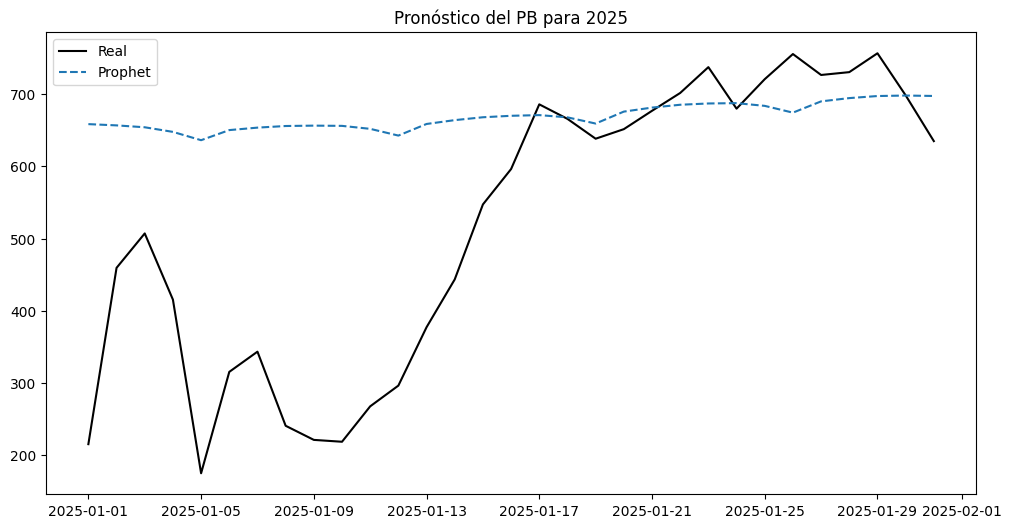

           Prophet
MSE   55464.022308
RMSE    235.508009
MAPE      0.594373


In [111]:
# Evaluación
#results = pd.DataFrame({'Real': test['Precio Bolsa Nacional'], 'SARIMA': sarima_forecast.values, 'Prophet': prophet_forecast.values})
results = pd.DataFrame({'Real': test['Precio Bolsa Nacional'], 'Prophet': prophet_forecast.values})#
results.dropna(inplace=True)

metrics = {
    'MSE': lambda y, y_pred: mean_squared_error(y, y_pred),
    'RMSE': lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)),
    'MAPE': lambda y, y_pred: mean_absolute_percentage_error(y, y_pred)
}

#comparison = pd.DataFrame({model: [func(results['Real'], results[model]) for func in metrics.values()]
#                           for model in ['SARIMA', 'Prophet']}, index=metrics.keys())

comparison = pd.DataFrame({model: [func(results['Real'], results[model]) for func in metrics.values()]
                           for model in ['Prophet']}, index=metrics.keys())

# Visualización
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Precio Bolsa Nacional'], label='Real', color='black')
#plt.plot(test.index, sarima_forecast, label='SARIMA', linestyle='dashed')
plt.plot(test.index, prophet_forecast, label='Prophet', linestyle='dashed')
plt.legend()
plt.title('Pronóstico del PB para 2025')
plt.show()

print(comparison)

In [112]:
# Exportar resultados
output_df = pd.DataFrame({
    'Fecha': test.index,
    #'PB_SARIMA': sarima_forecast.values,
    'PB_Prophet': prophet_forecast.values,
    'Demanda_Esperada': forecast_data['Demanda Comercial'].reindex(test.index),
    'ONI_Esperado': forecast_data['ONI'].reindex(test.index)
})
output_df.to_csv('pb_output_dia.csv', index=False)


In [101]:
output_df

,Fecha,PB_Prophet,Demanda_Esperada,ONI_Esperado
2025-01-01,2025-01-01,658.362302,NaN,NaN
2025-01-02,2025-01-02,656.620988,NaN,NaN
2025-01-03,2025-01-03,654.006309,NaN,NaN
2025-01-04,2025-01-04,647.632485,NaN,NaN
2025-01-05,2025-01-05,636.127624,NaN,NaN
...,...,...,...,...
2025-12-27,2025-12-27,769.617583,220.88,0.3
2025-12-28,2025-12-28,756.347937,220.88,0.3
2025-12-29,2025-12-29,768.281400,238.08,0.3
2025-12-30,2025-12-30,769.417661,238.08,0.3
